# mini5. 중간 프로젝트
## 5팀 : 심전근 뇌졸증 진단 프로그램
1. Heart Failure Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction   
데이터 이름 : 'Healthcare-Stroke.csv'   
데이터 포맷 : (row, col)   
메타데이터 :   
    - id : 고유 식별자
    - gender : 환자의 성별
    - age : 환자의 연령
    - hypertension : 환자가 고혈압이 아닌 경우 0, 고혈압인 경우 1
    - heart_parament : 환자가 심장 질환이 없는 경우 0, 환자가 심장 질환이 있는 경우 1
    - ever_married : 결혼한 적이 있는가 "아니오" 또는 "예"
    - work_type : "Children", "Govt_jov", "Never_worked", "Private" 또는 "Self-employed"
    - Residence_type : "Rural" or "Urban”
    - avg_glucose_level : 혈중 평균 포도당 수준
    - bmi : 체질량지수
    - smoking_status : "formerly smoked", "never smoked", "smokes" or "Unknown"
    - stroke : 뇌졸중이 있는 경우 1, 뇌졸중이 아닌 경우 0
    - 참고 : smoking_status의 Unknown은 이 환자에 대한 정보를 사용할 수 없음을 의미한다. 
   

2. Stroke Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset   
데이터 이름 : 'Healthcare-Heart.csv'   
데이터 포맷 : (row, col)   
메타데이터 :  
    - Age : 환자의 나이
    - Sex : 환자의 성별
    - ChestPainType : 흉통 유형
        TA : 일반 협심증,  ATA : 비정형 협심증,  NAP : 비혈관 통증,  ASY : 무증상
    - RestingBP : 휴면혈압[mmHg]
    - Cholesterol : 혈청 콜레스테롤 [mm/dl]
    - FastingBS : 금식혈당
        1 : 금식인 경우BS > 120 mg/dl
        0 : 그렇지 않은 경우
    - RestingECG : 심전도 결과
        정상 : 정상
        ST : ST-T파 이상(T파 반전 및/또는 ST 상승 또는 0.05mV 이상 하강)
        LVH : Estes의 기준에 의해 발생가능하거나 확실한 좌심실 비대
    - MaxHR : 달성된 최대 심박수 (60 ~ 202)
    - ExerciseAngina : 운동으로 인한 협심증 Y/N
    - Oldpeak : 이전 피크 = ST [저하 상태에서 측정된 숫자 값]
    - ST_Slope : 피크 연습 ST 세그먼트의 기울기 [위: 상향, 평탄: 하향: 하향]
    - HeartDisease : 1 심장 질환,  0 정상 

## 0. 환경설정

### 라이브러리 호출

In [49]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from imblearn.over_sampling import SMOTE

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn Module Import
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

from xgboost import XGBClassifier, plot_importance

### 시각화 한글 폰트 설정

In [2]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'Malgun Gothic'

### 그래프 색상 그라데이션 설정

In [3]:
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,256),0).T
    ax = bars[0].axes 
    lim = ax.get_xlim()+ax.get_ylim() 
    for bar in bars:
        bar.set_facecolor("none") 
        x,y = bar.get_xy() 
        w, h = bar.get_width(), bar.get_height() 
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) 
    ax.axis(lim)

### 사용자 함수 정의

In [4]:
# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#     return [acc, pre, rec, f1]

# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
# 상관관계 히트맵 함수
def corr_plot(data, cmap, width, height, title):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr))

    plt.figure(figsize=(width, height))
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, vmin=-1, vmax=1, fmt=".2f")
    plt.title(title, fontsize=20)
    plt.show()
    

# 혼동행렬 시각화 함수
def plot_confusion_matrix(cm, class_names, figsize=(8, 8)):
    cm = cm.numpy()
    figure = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure    

## 1. 데이터 로드
### Healthcare-Stroke.csv (row, col)

In [5]:
# Data Load
def data_load(path, file):
    df = pd.read_csv(f"{path}{file}", sep=",")
    return df

path = 'data/'
file = 'Healthcare-Stroke.csv'

In [6]:
df = data_load(path, file)
print('df.shape :',df.shape)
df.head()

df.shape : (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [8]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
# data describe
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 2. 데이터 전처리

In [10]:
# 의미없는 'ID'특성 제거
df = df[df.columns.difference(['id'])]
df.shape

(5110, 11)

### LabelEncoding

In [11]:
# LabelEncoding
cat_list = ['gender','ever_married','work_type','Residence_type','smoking_status']
for cat in cat_list:
    l_encoder = LabelEncoder()
    l_encoder.fit(df[cat])
    labels = l_encoder.transform(df[cat])
    df[cat] = labels

    print(cat,':',l_encoder.classes_)
    print(cat,'encoded :',np.unique(labels),'\n')

gender : ['Female' 'Male' 'Other']
gender encoded : [0 1 2] 

ever_married : ['No' 'Yes']
ever_married encoded : [0 1] 

work_type : ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
work_type encoded : [0 1 2 3 4] 

Residence_type : ['Rural' 'Urban']
Residence_type encoded : [0 1] 

smoking_status : ['Unknown' 'formerly smoked' 'never smoked' 'smokes']
smoking_status encoded : [0 1 2 3] 



### MissingValue Processing

In [12]:
# gender = 2로 표기되어 있는 사람은 성별을 알 수 없으므로 제거.
df[df['gender'] == 2]

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
3116,0,26.0,143.33,22.4,0,2,0,0,1,0,2


In [13]:
df.drop(index = df[df['gender'] == 2].index, inplace=True)

In [14]:
# bmi 칼럼의 nan값들을 평균값으로 대치
df['bmi'].fillna(df['bmi'].mean(), axis=0,inplace=True)

### Outlier Processing

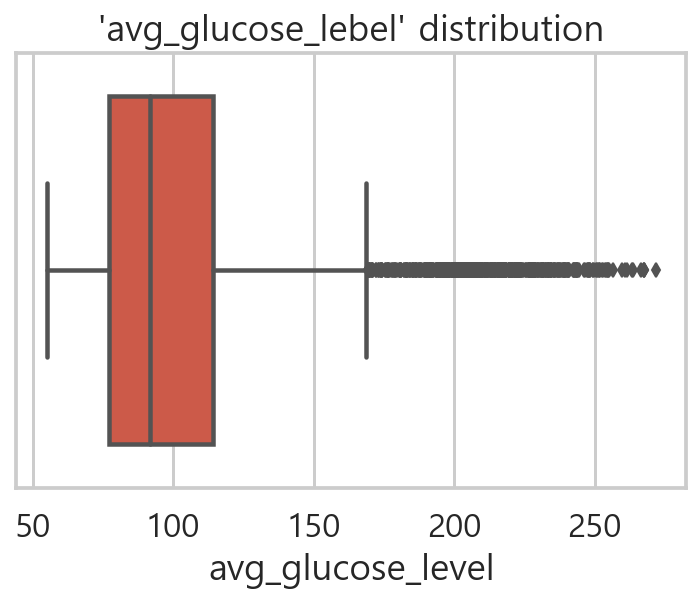

In [15]:
plt.title("'avg_glucose_lebel' distribution")
sns.boxplot(df['avg_glucose_level'])
plt.show()

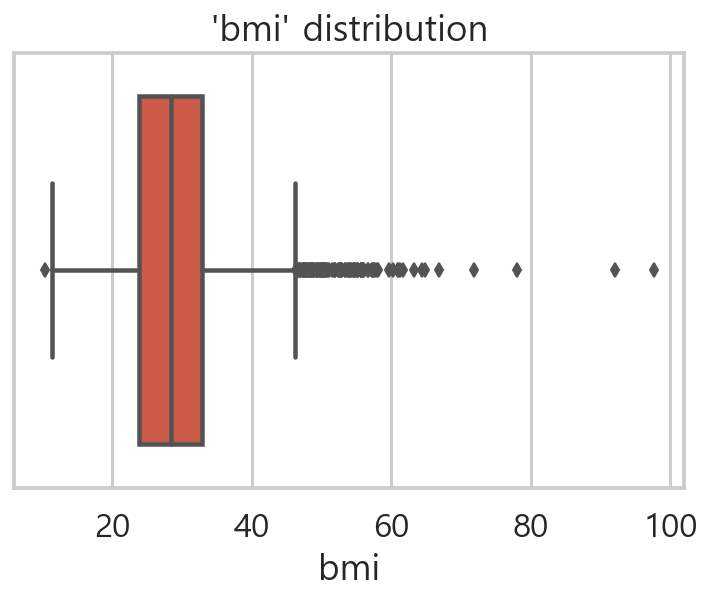

In [16]:
plt.title("'bmi' distribution")
sns.boxplot(df['bmi'])
plt.show()

In [17]:
# bmi 칼럼의 상위 4 개의 이상치에 대해 최대값으로 대치
df.loc[df['bmi'].sort_values(ascending=False)[:4].index,'bmi'] = df['bmi'].sort_values(ascending=False)[:5].values[-1]

## 3. 데이터 EDA

### Histogram

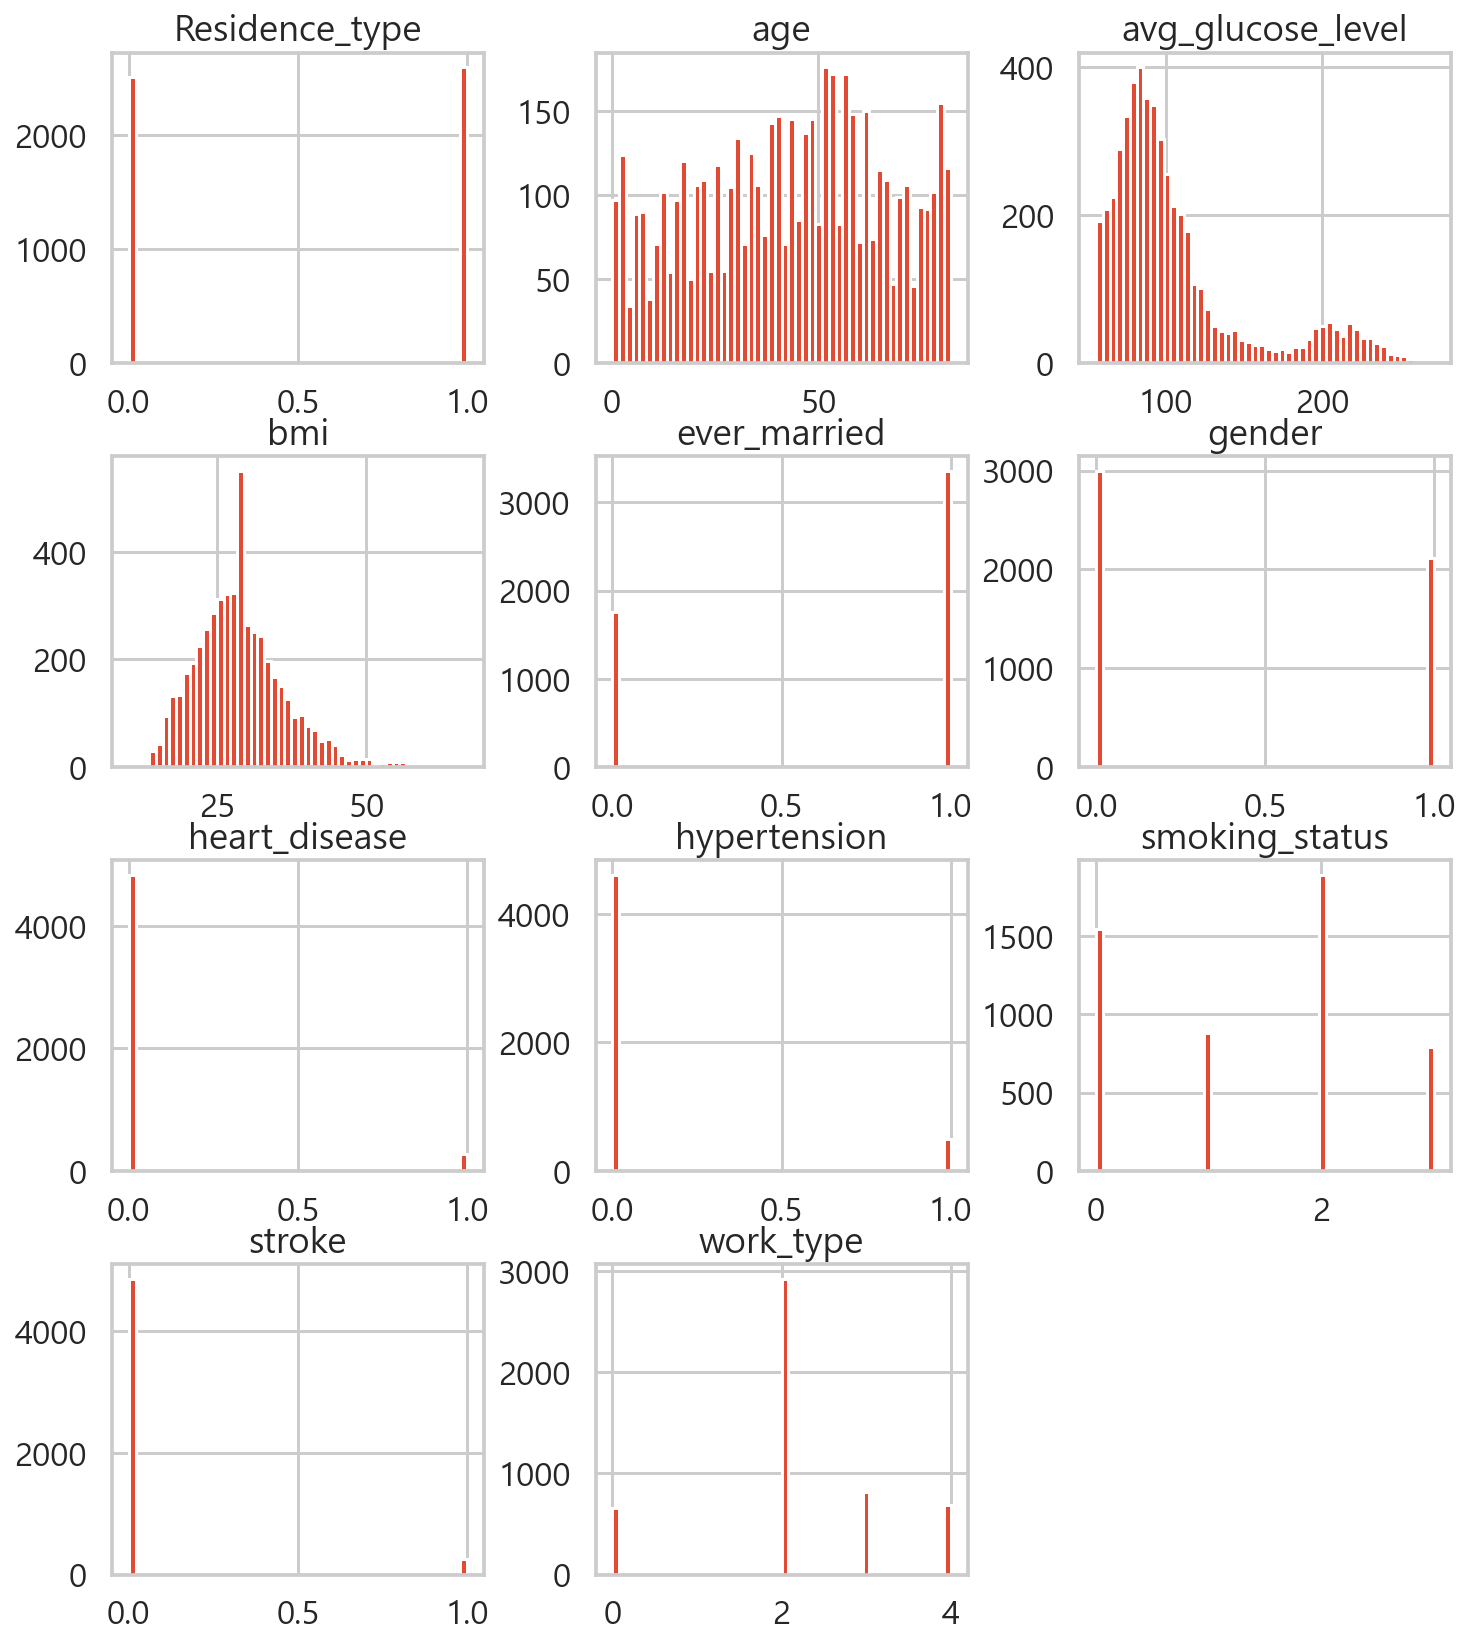

In [18]:
# Histogram
df.hist(figsize=(12,14),bins=50)
plt.show()

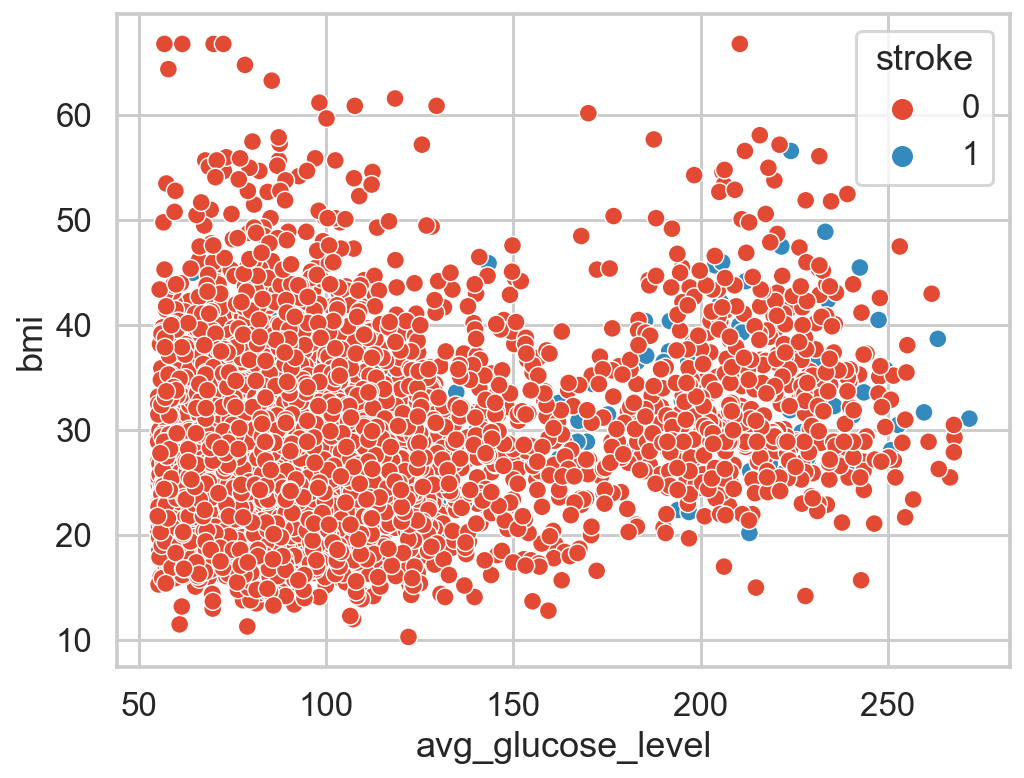

In [99]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='avg_glucose_level', y='bmi', hue='stroke')
plt.show()

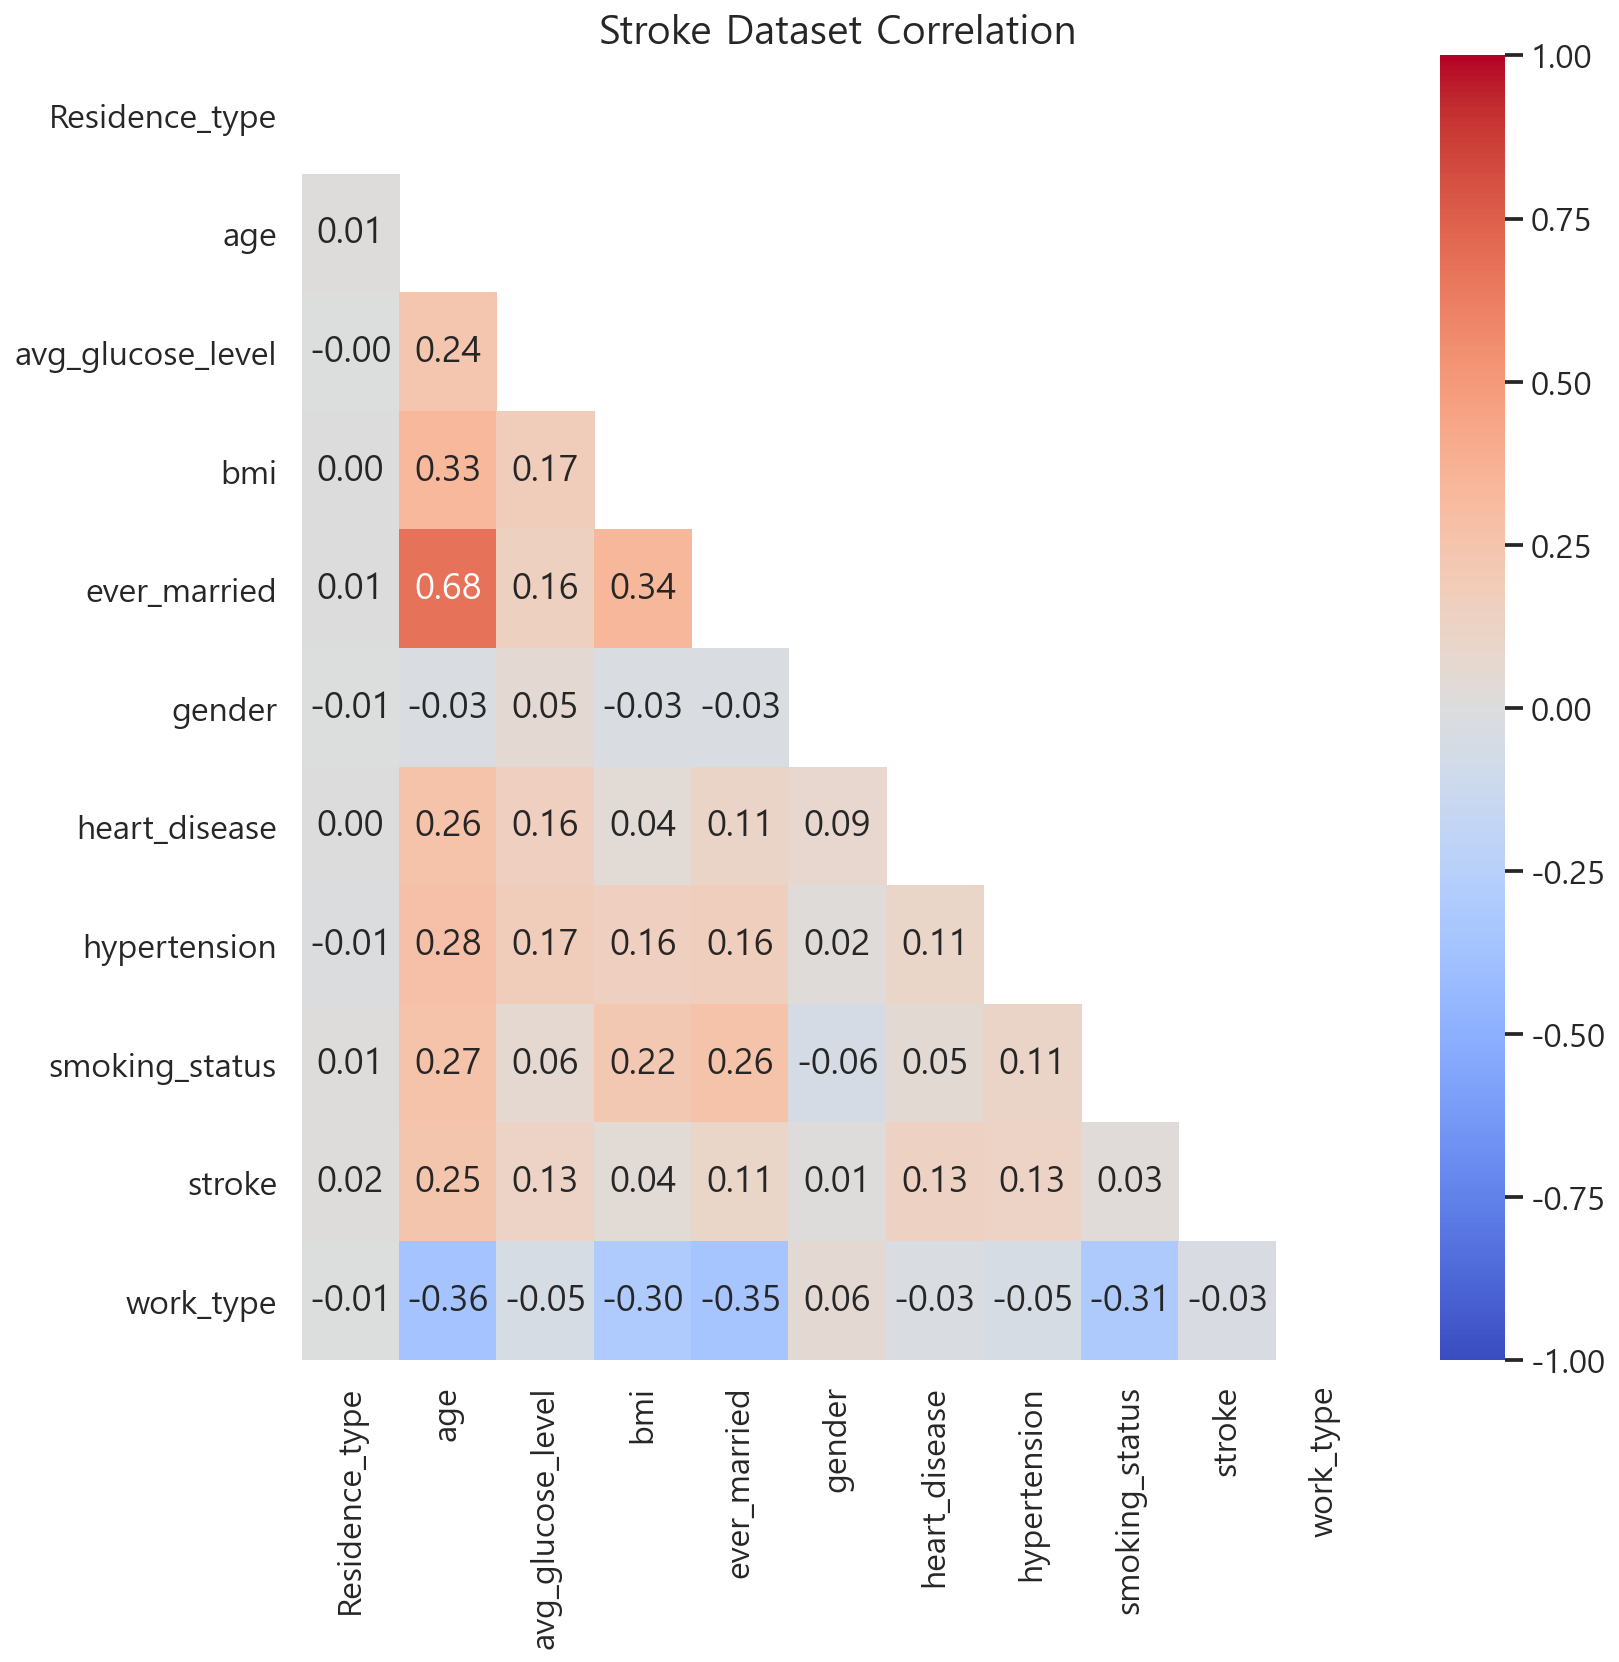

In [19]:
corr_plot(df, 'coolwarm',12, 12, 'Stroke Dataset Correlation')

## 4. ML Model Train

In [20]:
print('df.shape :',df.shape)
df.head()

df.shape : (5109, 11)


,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
0,1,67.0,228.69,36.60000,1,1,1,0,1,1,2
1,0,61.0,202.21,28.89456,1,0,0,0,2,1,3
2,0,80.0,105.92,32.50000,1,1,1,0,2,1,2
3,1,49.0,171.23,34.40000,1,0,0,0,3,1,2
4,0,79.0,174.12,24.00000,1,0,0,1,2,1,3


### 데이터 분할

In [21]:
X_data = df.drop('stroke',axis=1)
y_data = df['stroke']
print('X_data.shape :',X_data.shape)
print('y_data.shape :',y_data.shape,'\n')

X_train, X_test, y_train, y_test = train_test_split(X_data.to_numpy(), y_data, test_size=0.2, stratify = y_data,
                                                   shuffle=True, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_test.shape)
print('y_Test.shape :',y_test.shape)

X_data.shape : (5109, 10)
y_data.shape : (5109,) 

X_train.shape : (4087, 10)
y_train.shape : (4087,)
X_test.shape : (1022, 10)
y_Test.shape : (1022,)


### 데이터 오버샘플링

In [26]:
sm = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print('X_smote.shape :',X_smote.shape)
print('y_smote.shape :',y_smote.shape)

X_smote.shape : (7776, 10)
y_smote.shape : (7776,)


In [29]:
y_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: stroke, dtype: float64

### GridSearchCV

In [51]:
# 하이퍼파라미터 튜닝
model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth = 3)
evals = [(X_test,y_test)]
param_grid = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300,400],
}

grid_cv = GridSearchCV(model, cv=3, refit=True, param_grid=param_grid)
grid_cv.fit(X_smote, y_smote, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

[0]	validation_0-logloss:0.68835
[1]	validation_0-logloss:0.68402
[2]	validation_0-logloss:0.67941
[3]	validation_0-logloss:0.67521
[4]	validation_0-logloss:0.67077
[5]	validation_0-logloss:0.66675
[6]	validation_0-logloss:0.66281
[7]	validation_0-logloss:0.65860
[8]	validation_0-logloss:0.65482
[9]	validation_0-logloss:0.65077
[10]	validation_0-logloss:0.64712
[11]	validation_0-logloss:0.64321
[12]	validation_0-logloss:0.63972
[13]	validation_0-logloss:0.63594
[14]	validation_0-logloss:0.63257
[15]	validation_0-logloss:0.62892
[16]	validation_0-logloss:0.62568
[17]	validation_0-logloss:0.62216
[18]	validation_0-logloss:0.61902
[19]	validation_0-logloss:0.61561
[20]	validation_0-logloss:0.61260
[21]	validation_0-logloss:0.60930
[22]	validation_0-logloss:0.60639
[23]	validation_0-logloss:0.60320
[24]	validation_0-logloss:0.60040
[25]	validation_0-logloss:0.59730
[26]	validation_0-logloss:0.59459
[27]	validation_0-logloss:0.59159
[28]	validation_0-logloss:0.58898
[29]	validation_0-loglos

[42]	validation_0-logloss:0.55514
[43]	validation_0-logloss:0.55313
[44]	validation_0-logloss:0.55070
[45]	validation_0-logloss:0.54856
[46]	validation_0-logloss:0.54617
[47]	validation_0-logloss:0.54377
[48]	validation_0-logloss:0.54161
[49]	validation_0-logloss:0.53936
[50]	validation_0-logloss:0.53755
[51]	validation_0-logloss:0.53520
[52]	validation_0-logloss:0.53290
[53]	validation_0-logloss:0.53062
[54]	validation_0-logloss:0.52867
[55]	validation_0-logloss:0.52687
[56]	validation_0-logloss:0.52464
[57]	validation_0-logloss:0.52272
[58]	validation_0-logloss:0.52065
[59]	validation_0-logloss:0.51853
[60]	validation_0-logloss:0.51670
[61]	validation_0-logloss:0.51460
[62]	validation_0-logloss:0.51267
[63]	validation_0-logloss:0.51087
[64]	validation_0-logloss:0.50887
[65]	validation_0-logloss:0.50716
[66]	validation_0-logloss:0.50565
[67]	validation_0-logloss:0.50367
[68]	validation_0-logloss:0.50199
[69]	validation_0-logloss:0.50019
[70]	validation_0-logloss:0.49828
[71]	validatio

[181]	validation_0-logloss:0.35849
[182]	validation_0-logloss:0.35775
[183]	validation_0-logloss:0.35683
[184]	validation_0-logloss:0.35574
[185]	validation_0-logloss:0.35502
[186]	validation_0-logloss:0.35445
[187]	validation_0-logloss:0.35337
[188]	validation_0-logloss:0.35267
[189]	validation_0-logloss:0.35162
[190]	validation_0-logloss:0.35069
[191]	validation_0-logloss:0.35000
[192]	validation_0-logloss:0.34897
[193]	validation_0-logloss:0.34806
[194]	validation_0-logloss:0.34739
[195]	validation_0-logloss:0.34638
[196]	validation_0-logloss:0.34573
[197]	validation_0-logloss:0.34516
[198]	validation_0-logloss:0.34416
[199]	validation_0-logloss:0.34352
[0]	validation_0-logloss:0.68847
[1]	validation_0-logloss:0.68389
[2]	validation_0-logloss:0.67940
[3]	validation_0-logloss:0.67512
[4]	validation_0-logloss:0.67081
[5]	validation_0-logloss:0.66671
[6]	validation_0-logloss:0.66256
[7]	validation_0-logloss:0.65862
[8]	validation_0-logloss:0.65463
[9]	validation_0-logloss:0.65084
[10]	

[20]	validation_0-logloss:0.61416
[21]	validation_0-logloss:0.61089
[22]	validation_0-logloss:0.60790
[23]	validation_0-logloss:0.60504
[24]	validation_0-logloss:0.60178
[25]	validation_0-logloss:0.59893
[26]	validation_0-logloss:0.59619
[27]	validation_0-logloss:0.59315
[28]	validation_0-logloss:0.59038
[29]	validation_0-logloss:0.58741
[30]	validation_0-logloss:0.58470
[31]	validation_0-logloss:0.58227
[32]	validation_0-logloss:0.57937
[33]	validation_0-logloss:0.57687
[34]	validation_0-logloss:0.57446
[35]	validation_0-logloss:0.57175
[36]	validation_0-logloss:0.56938
[37]	validation_0-logloss:0.56695
[38]	validation_0-logloss:0.56436
[39]	validation_0-logloss:0.56219
[40]	validation_0-logloss:0.55989
[41]	validation_0-logloss:0.55740
[42]	validation_0-logloss:0.55514
[43]	validation_0-logloss:0.55313
[44]	validation_0-logloss:0.55070
[45]	validation_0-logloss:0.54856
[46]	validation_0-logloss:0.54617
[47]	validation_0-logloss:0.54377
[48]	validation_0-logloss:0.54161
[49]	validatio

[59]	validation_0-logloss:0.51571
[60]	validation_0-logloss:0.51343
[61]	validation_0-logloss:0.51152
[62]	validation_0-logloss:0.50929
[63]	validation_0-logloss:0.50709
[64]	validation_0-logloss:0.50496
[65]	validation_0-logloss:0.50281
[66]	validation_0-logloss:0.50099
[67]	validation_0-logloss:0.49878
[68]	validation_0-logloss:0.49673
[69]	validation_0-logloss:0.49469
[70]	validation_0-logloss:0.49295
[71]	validation_0-logloss:0.49100
[72]	validation_0-logloss:0.48967
[73]	validation_0-logloss:0.48756
[74]	validation_0-logloss:0.48556
[75]	validation_0-logloss:0.48371
[76]	validation_0-logloss:0.48167
[77]	validation_0-logloss:0.48012
[78]	validation_0-logloss:0.47812
[79]	validation_0-logloss:0.47634
[80]	validation_0-logloss:0.47439
[81]	validation_0-logloss:0.47289
[82]	validation_0-logloss:0.47098
[83]	validation_0-logloss:0.46910
[84]	validation_0-logloss:0.46762
[85]	validation_0-logloss:0.46573
[86]	validation_0-logloss:0.46402
[87]	validation_0-logloss:0.46265
[88]	validatio

[295]	validation_0-logloss:0.28110
[296]	validation_0-logloss:0.28075
[297]	validation_0-logloss:0.28015
[298]	validation_0-logloss:0.27939
[299]	validation_0-logloss:0.27907
[0]	validation_0-logloss:0.68847
[1]	validation_0-logloss:0.68389
[2]	validation_0-logloss:0.67940
[3]	validation_0-logloss:0.67512
[4]	validation_0-logloss:0.67081
[5]	validation_0-logloss:0.66671
[6]	validation_0-logloss:0.66256
[7]	validation_0-logloss:0.65862
[8]	validation_0-logloss:0.65463
[9]	validation_0-logloss:0.65084
[10]	validation_0-logloss:0.64700
[11]	validation_0-logloss:0.64353
[12]	validation_0-logloss:0.63995
[13]	validation_0-logloss:0.63646
[14]	validation_0-logloss:0.63318
[15]	validation_0-logloss:0.62981
[16]	validation_0-logloss:0.62665
[17]	validation_0-logloss:0.62338
[18]	validation_0-logloss:0.62037
[19]	validation_0-logloss:0.61721
[20]	validation_0-logloss:0.61427
[21]	validation_0-logloss:0.61109
[22]	validation_0-logloss:0.60826
[23]	validation_0-logloss:0.60531
[24]	validation_0-l

[233]	validation_0-logloss:0.34020
[234]	validation_0-logloss:0.33974
[235]	validation_0-logloss:0.33889
[236]	validation_0-logloss:0.33822
[237]	validation_0-logloss:0.33758
[238]	validation_0-logloss:0.33712
[239]	validation_0-logloss:0.33645
[240]	validation_0-logloss:0.33563
[241]	validation_0-logloss:0.33525
[242]	validation_0-logloss:0.33484
[243]	validation_0-logloss:0.33422
[244]	validation_0-logloss:0.33378
[245]	validation_0-logloss:0.33339
[246]	validation_0-logloss:0.33295
[247]	validation_0-logloss:0.33201
[248]	validation_0-logloss:0.33113
[249]	validation_0-logloss:0.33077
[250]	validation_0-logloss:0.33034
[251]	validation_0-logloss:0.32948
[252]	validation_0-logloss:0.32906
[253]	validation_0-logloss:0.32864
[254]	validation_0-logloss:0.32777
[255]	validation_0-logloss:0.32687
[256]	validation_0-logloss:0.32653
[257]	validation_0-logloss:0.32570
[258]	validation_0-logloss:0.32486
[259]	validation_0-logloss:0.32445
[260]	validation_0-logloss:0.32403
[261]	validation_0-l

[171]	validation_0-logloss:0.37637
[172]	validation_0-logloss:0.37574
[173]	validation_0-logloss:0.37490
[174]	validation_0-logloss:0.37398
[175]	validation_0-logloss:0.37315
[176]	validation_0-logloss:0.37253
[177]	validation_0-logloss:0.37177
[178]	validation_0-logloss:0.37090
[179]	validation_0-logloss:0.37005
[180]	validation_0-logloss:0.36929
[181]	validation_0-logloss:0.36872
[182]	validation_0-logloss:0.36799
[183]	validation_0-logloss:0.36725
[184]	validation_0-logloss:0.36643
[185]	validation_0-logloss:0.36590
[186]	validation_0-logloss:0.36518
[187]	validation_0-logloss:0.36442
[188]	validation_0-logloss:0.36390
[189]	validation_0-logloss:0.36319
[190]	validation_0-logloss:0.36268
[191]	validation_0-logloss:0.36198
[192]	validation_0-logloss:0.36112
[193]	validation_0-logloss:0.36039
[194]	validation_0-logloss:0.35960
[195]	validation_0-logloss:0.35910
[196]	validation_0-logloss:0.35826
[197]	validation_0-logloss:0.35755
[198]	validation_0-logloss:0.35696
[199]	validation_0-l

[109]	validation_0-logloss:0.43101
[110]	validation_0-logloss:0.42990
[111]	validation_0-logloss:0.42850
[112]	validation_0-logloss:0.42716
[113]	validation_0-logloss:0.42597
[114]	validation_0-logloss:0.42455
[115]	validation_0-logloss:0.42319
[116]	validation_0-logloss:0.42203
[117]	validation_0-logloss:0.42075
[118]	validation_0-logloss:0.41944
[119]	validation_0-logloss:0.41813
[120]	validation_0-logloss:0.41706
[121]	validation_0-logloss:0.41575
[122]	validation_0-logloss:0.41465
[123]	validation_0-logloss:0.41353
[124]	validation_0-logloss:0.41227
[125]	validation_0-logloss:0.41119
[126]	validation_0-logloss:0.41013
[127]	validation_0-logloss:0.40882
[128]	validation_0-logloss:0.40771
[129]	validation_0-logloss:0.40639
[130]	validation_0-logloss:0.40556
[131]	validation_0-logloss:0.40435
[132]	validation_0-logloss:0.40334
[133]	validation_0-logloss:0.40216
[134]	validation_0-logloss:0.40096
[135]	validation_0-logloss:0.39998
[136]	validation_0-logloss:0.39873
[137]	validation_0-l

[344]	validation_0-logloss:0.25874
[345]	validation_0-logloss:0.25840
[346]	validation_0-logloss:0.25812
[347]	validation_0-logloss:0.25787
[348]	validation_0-logloss:0.25733
[349]	validation_0-logloss:0.25667
[350]	validation_0-logloss:0.25619
[351]	validation_0-logloss:0.25576
[352]	validation_0-logloss:0.25552
[353]	validation_0-logloss:0.25500
[354]	validation_0-logloss:0.25469
[355]	validation_0-logloss:0.25418
[356]	validation_0-logloss:0.25383
[357]	validation_0-logloss:0.25333
[358]	validation_0-logloss:0.25287
[359]	validation_0-logloss:0.25255
[360]	validation_0-logloss:0.25210
[361]	validation_0-logloss:0.25174
[362]	validation_0-logloss:0.25105
[363]	validation_0-logloss:0.25081
[364]	validation_0-logloss:0.25012
[365]	validation_0-logloss:0.24990
[366]	validation_0-logloss:0.24923
[367]	validation_0-logloss:0.24899
[368]	validation_0-logloss:0.24876
[369]	validation_0-logloss:0.24833
[370]	validation_0-logloss:0.24787
[371]	validation_0-logloss:0.24765
[372]	validation_0-l

[182]	validation_0-logloss:0.37304
[183]	validation_0-logloss:0.37252
[184]	validation_0-logloss:0.37188
[185]	validation_0-logloss:0.37121
[186]	validation_0-logloss:0.37033
[187]	validation_0-logloss:0.36980
[188]	validation_0-logloss:0.36915
[189]	validation_0-logloss:0.36849
[190]	validation_0-logloss:0.36785
[191]	validation_0-logloss:0.36698
[192]	validation_0-logloss:0.36634
[193]	validation_0-logloss:0.36571
[194]	validation_0-logloss:0.36484
[195]	validation_0-logloss:0.36423
[196]	validation_0-logloss:0.36356
[197]	validation_0-logloss:0.36295
[198]	validation_0-logloss:0.36234
[199]	validation_0-logloss:0.36150
[200]	validation_0-logloss:0.36091
[201]	validation_0-logloss:0.36008
[202]	validation_0-logloss:0.35940
[203]	validation_0-logloss:0.35883
[204]	validation_0-logloss:0.35803
[205]	validation_0-logloss:0.35736
[206]	validation_0-logloss:0.35681
[207]	validation_0-logloss:0.35623
[208]	validation_0-logloss:0.35544
[209]	validation_0-logloss:0.35490
[210]	validation_0-l

[17]	validation_0-logloss:0.62336
[18]	validation_0-logloss:0.62031
[19]	validation_0-logloss:0.61707
[20]	validation_0-logloss:0.61416
[21]	validation_0-logloss:0.61089
[22]	validation_0-logloss:0.60790
[23]	validation_0-logloss:0.60504
[24]	validation_0-logloss:0.60178
[25]	validation_0-logloss:0.59893
[26]	validation_0-logloss:0.59619
[27]	validation_0-logloss:0.59315
[28]	validation_0-logloss:0.59038
[29]	validation_0-logloss:0.58741
[30]	validation_0-logloss:0.58470
[31]	validation_0-logloss:0.58227
[32]	validation_0-logloss:0.57937
[33]	validation_0-logloss:0.57687
[34]	validation_0-logloss:0.57446
[35]	validation_0-logloss:0.57175
[36]	validation_0-logloss:0.56938
[37]	validation_0-logloss:0.56695
[38]	validation_0-logloss:0.56436
[39]	validation_0-logloss:0.56219
[40]	validation_0-logloss:0.55989
[41]	validation_0-logloss:0.55740
[42]	validation_0-logloss:0.55514
[43]	validation_0-logloss:0.55313
[44]	validation_0-logloss:0.55070
[45]	validation_0-logloss:0.54856
[46]	validatio

[254]	validation_0-logloss:0.32009
[255]	validation_0-logloss:0.31974
[256]	validation_0-logloss:0.31916
[257]	validation_0-logloss:0.31850
[258]	validation_0-logloss:0.31801
[259]	validation_0-logloss:0.31746
[260]	validation_0-logloss:0.31673
[261]	validation_0-logloss:0.31617
[262]	validation_0-logloss:0.31567
[263]	validation_0-logloss:0.31491
[264]	validation_0-logloss:0.31428
[265]	validation_0-logloss:0.31394
[266]	validation_0-logloss:0.31340
[267]	validation_0-logloss:0.31267
[268]	validation_0-logloss:0.31215
[269]	validation_0-logloss:0.31141
[270]	validation_0-logloss:0.31106
[271]	validation_0-logloss:0.31045
[272]	validation_0-logloss:0.30973
[273]	validation_0-logloss:0.30926
[274]	validation_0-logloss:0.30874
[275]	validation_0-logloss:0.30807
[276]	validation_0-logloss:0.30737
[277]	validation_0-logloss:0.30704
[278]	validation_0-logloss:0.30645
[279]	validation_0-logloss:0.30595
[280]	validation_0-logloss:0.30545
[281]	validation_0-logloss:0.30478
[282]	validation_0-l

[91]	validation_0-logloss:0.22066
[92]	validation_0-logloss:0.21890
[93]	validation_0-logloss:0.21799
[94]	validation_0-logloss:0.21738
[95]	validation_0-logloss:0.21519
[96]	validation_0-logloss:0.21458
[97]	validation_0-logloss:0.21259
[98]	validation_0-logloss:0.21152
[99]	validation_0-logloss:0.21080
[0]	validation_0-logloss:0.67027
[1]	validation_0-logloss:0.65025
[2]	validation_0-logloss:0.63067
[3]	validation_0-logloss:0.61517
[4]	validation_0-logloss:0.59991
[5]	validation_0-logloss:0.58685
[6]	validation_0-logloss:0.57371
[7]	validation_0-logloss:0.56081
[8]	validation_0-logloss:0.54707
[9]	validation_0-logloss:0.53769
[10]	validation_0-logloss:0.52573
[11]	validation_0-logloss:0.51404
[12]	validation_0-logloss:0.50337
[13]	validation_0-logloss:0.49542
[14]	validation_0-logloss:0.48614
[15]	validation_0-logloss:0.47691
[16]	validation_0-logloss:0.47021
[17]	validation_0-logloss:0.46222
[18]	validation_0-logloss:0.45456
[19]	validation_0-logloss:0.44957
[20]	validation_0-loglos

[33]	validation_0-logloss:0.36838
[34]	validation_0-logloss:0.36439
[35]	validation_0-logloss:0.35955
[36]	validation_0-logloss:0.35404
[37]	validation_0-logloss:0.35053
[38]	validation_0-logloss:0.34596
[39]	validation_0-logloss:0.34102
[40]	validation_0-logloss:0.33788
[41]	validation_0-logloss:0.33519
[42]	validation_0-logloss:0.33071
[43]	validation_0-logloss:0.32585
[44]	validation_0-logloss:0.32293
[45]	validation_0-logloss:0.32010
[46]	validation_0-logloss:0.31766
[47]	validation_0-logloss:0.31293
[48]	validation_0-logloss:0.31044
[49]	validation_0-logloss:0.30832
[50]	validation_0-logloss:0.30405
[51]	validation_0-logloss:0.29938
[52]	validation_0-logloss:0.29730
[53]	validation_0-logloss:0.29514
[54]	validation_0-logloss:0.29092
[55]	validation_0-logloss:0.28724
[56]	validation_0-logloss:0.28549
[57]	validation_0-logloss:0.28363
[58]	validation_0-logloss:0.27985
[59]	validation_0-logloss:0.27683
[60]	validation_0-logloss:0.27518
[61]	validation_0-logloss:0.27350
[62]	validatio

[72]	validation_0-logloss:0.27097
[73]	validation_0-logloss:0.26873
[74]	validation_0-logloss:0.26583
[75]	validation_0-logloss:0.26498
[76]	validation_0-logloss:0.26367
[77]	validation_0-logloss:0.26168
[78]	validation_0-logloss:0.26078
[79]	validation_0-logloss:0.25821
[80]	validation_0-logloss:0.25697
[81]	validation_0-logloss:0.25567
[82]	validation_0-logloss:0.25394
[83]	validation_0-logloss:0.25277
[84]	validation_0-logloss:0.25055
[85]	validation_0-logloss:0.24991
[86]	validation_0-logloss:0.24893
[87]	validation_0-logloss:0.24732
[88]	validation_0-logloss:0.24632
[89]	validation_0-logloss:0.24529
[90]	validation_0-logloss:0.24404
[91]	validation_0-logloss:0.24311
[92]	validation_0-logloss:0.24234
[93]	validation_0-logloss:0.24088
[94]	validation_0-logloss:0.23972
[95]	validation_0-logloss:0.23778
[96]	validation_0-logloss:0.23697
[97]	validation_0-logloss:0.23523
[98]	validation_0-logloss:0.23463
[99]	validation_0-logloss:0.23295
[100]	validation_0-logloss:0.23251
[101]	validat

[111]	validation_0-logloss:0.22334
[112]	validation_0-logloss:0.22202
[113]	validation_0-logloss:0.22123
[114]	validation_0-logloss:0.22037
[115]	validation_0-logloss:0.21984
[116]	validation_0-logloss:0.21923
[117]	validation_0-logloss:0.21846
[118]	validation_0-logloss:0.21780
[119]	validation_0-logloss:0.21713
[120]	validation_0-logloss:0.21583
[121]	validation_0-logloss:0.21536
[122]	validation_0-logloss:0.21505
[123]	validation_0-logloss:0.21457
[124]	validation_0-logloss:0.21352
[125]	validation_0-logloss:0.21328
[126]	validation_0-logloss:0.21237
[127]	validation_0-logloss:0.21202
[128]	validation_0-logloss:0.21173
[129]	validation_0-logloss:0.21131
[130]	validation_0-logloss:0.21046
[131]	validation_0-logloss:0.20964
[132]	validation_0-logloss:0.20908
[133]	validation_0-logloss:0.20834
[134]	validation_0-logloss:0.20782
[135]	validation_0-logloss:0.20730
[136]	validation_0-logloss:0.20683
[137]	validation_0-logloss:0.20635
[138]	validation_0-logloss:0.20610
[139]	validation_0-l

[149]	validation_0-logloss:0.18435
[150]	validation_0-logloss:0.18410
[151]	validation_0-logloss:0.18399
[152]	validation_0-logloss:0.18393
[153]	validation_0-logloss:0.18333
[154]	validation_0-logloss:0.18321
[155]	validation_0-logloss:0.18288
[156]	validation_0-logloss:0.18261
[157]	validation_0-logloss:0.18267
[158]	validation_0-logloss:0.18258
[159]	validation_0-logloss:0.18242
[160]	validation_0-logloss:0.18236
[161]	validation_0-logloss:0.18222
[162]	validation_0-logloss:0.18194
[163]	validation_0-logloss:0.18158
[164]	validation_0-logloss:0.18138
[165]	validation_0-logloss:0.18117
[166]	validation_0-logloss:0.18081
[167]	validation_0-logloss:0.18075
[168]	validation_0-logloss:0.18031
[169]	validation_0-logloss:0.18024
[170]	validation_0-logloss:0.18002
[171]	validation_0-logloss:0.17996
[172]	validation_0-logloss:0.17991
[173]	validation_0-logloss:0.17959
[174]	validation_0-logloss:0.17930
[175]	validation_0-logloss:0.17927
[176]	validation_0-logloss:0.17890
[177]	validation_0-l

[124]	validation_0-logloss:0.21484
[125]	validation_0-logloss:0.21457
[126]	validation_0-logloss:0.21413
[127]	validation_0-logloss:0.21339
[128]	validation_0-logloss:0.21306
[129]	validation_0-logloss:0.21207
[130]	validation_0-logloss:0.21190
[131]	validation_0-logloss:0.21166
[132]	validation_0-logloss:0.21110
[133]	validation_0-logloss:0.21067
[134]	validation_0-logloss:0.21030
[135]	validation_0-logloss:0.20983
[136]	validation_0-logloss:0.20961
[137]	validation_0-logloss:0.20896
[138]	validation_0-logloss:0.20851
[139]	validation_0-logloss:0.20795
[140]	validation_0-logloss:0.20761
[141]	validation_0-logloss:0.20676
[142]	validation_0-logloss:0.20644
[143]	validation_0-logloss:0.20610
[144]	validation_0-logloss:0.20553
[145]	validation_0-logloss:0.20524
[146]	validation_0-logloss:0.20497
[147]	validation_0-logloss:0.20456
[148]	validation_0-logloss:0.20380
[149]	validation_0-logloss:0.20356
[150]	validation_0-logloss:0.20348
[151]	validation_0-logloss:0.20301
[152]	validation_0-l

[61]	validation_0-logloss:0.29033
[62]	validation_0-logloss:0.28791
[63]	validation_0-logloss:0.28575
[64]	validation_0-logloss:0.28360
[65]	validation_0-logloss:0.28109
[66]	validation_0-logloss:0.27925
[67]	validation_0-logloss:0.27769
[68]	validation_0-logloss:0.27552
[69]	validation_0-logloss:0.27412
[70]	validation_0-logloss:0.27268
[71]	validation_0-logloss:0.27075
[72]	validation_0-logloss:0.26916
[73]	validation_0-logloss:0.26713
[74]	validation_0-logloss:0.26583
[75]	validation_0-logloss:0.26445
[76]	validation_0-logloss:0.26242
[77]	validation_0-logloss:0.26080
[78]	validation_0-logloss:0.25959
[79]	validation_0-logloss:0.25789
[80]	validation_0-logloss:0.25683
[81]	validation_0-logloss:0.25543
[82]	validation_0-logloss:0.25381
[83]	validation_0-logloss:0.25197
[84]	validation_0-logloss:0.25092
[85]	validation_0-logloss:0.24941
[86]	validation_0-logloss:0.24844
[87]	validation_0-logloss:0.24721
[88]	validation_0-logloss:0.24621
[89]	validation_0-logloss:0.24495
[90]	validatio

[297]	validation_0-logloss:0.17872
[298]	validation_0-logloss:0.17868
[299]	validation_0-logloss:0.17852
[0]	validation_0-logloss:0.66970
[1]	validation_0-logloss:0.65000
[2]	validation_0-logloss:0.63232
[3]	validation_0-logloss:0.61442
[4]	validation_0-logloss:0.59988
[5]	validation_0-logloss:0.58472
[6]	validation_0-logloss:0.57246
[7]	validation_0-logloss:0.55947
[8]	validation_0-logloss:0.54921
[9]	validation_0-logloss:0.53805
[10]	validation_0-logloss:0.52608
[11]	validation_0-logloss:0.51774
[12]	validation_0-logloss:0.50583
[13]	validation_0-logloss:0.49548
[14]	validation_0-logloss:0.48721
[15]	validation_0-logloss:0.47702
[16]	validation_0-logloss:0.46821
[17]	validation_0-logloss:0.45909
[18]	validation_0-logloss:0.45251
[19]	validation_0-logloss:0.44407
[20]	validation_0-logloss:0.43782
[21]	validation_0-logloss:0.43075
[22]	validation_0-logloss:0.42389
[23]	validation_0-logloss:0.41840
[24]	validation_0-logloss:0.41301
[25]	validation_0-logloss:0.40666
[26]	validation_0-log

[235]	validation_0-logloss:0.17720
[236]	validation_0-logloss:0.17722
[237]	validation_0-logloss:0.17733
[238]	validation_0-logloss:0.17741
[239]	validation_0-logloss:0.17759
[240]	validation_0-logloss:0.17762
[241]	validation_0-logloss:0.17761
[242]	validation_0-logloss:0.17762
[243]	validation_0-logloss:0.17772
[244]	validation_0-logloss:0.17769
[245]	validation_0-logloss:0.17781
[246]	validation_0-logloss:0.17788
[247]	validation_0-logloss:0.17807
[248]	validation_0-logloss:0.17815
[249]	validation_0-logloss:0.17817
[250]	validation_0-logloss:0.17818
[251]	validation_0-logloss:0.17817
[252]	validation_0-logloss:0.17823
[253]	validation_0-logloss:0.17834
[254]	validation_0-logloss:0.17868
[255]	validation_0-logloss:0.17880
[256]	validation_0-logloss:0.17881
[257]	validation_0-logloss:0.17899
[258]	validation_0-logloss:0.17916
[259]	validation_0-logloss:0.17912
[260]	validation_0-logloss:0.17925
[261]	validation_0-logloss:0.17933
[262]	validation_0-logloss:0.17937
[263]	validation_0-l

[209]	validation_0-logloss:0.18903
[210]	validation_0-logloss:0.18894
[211]	validation_0-logloss:0.18874
[212]	validation_0-logloss:0.18851
[213]	validation_0-logloss:0.18851
[214]	validation_0-logloss:0.18836
[215]	validation_0-logloss:0.18823
[216]	validation_0-logloss:0.18804
[217]	validation_0-logloss:0.18780
[218]	validation_0-logloss:0.18774
[219]	validation_0-logloss:0.18753
[220]	validation_0-logloss:0.18728
[221]	validation_0-logloss:0.18704
[222]	validation_0-logloss:0.18695
[223]	validation_0-logloss:0.18683
[224]	validation_0-logloss:0.18687
[225]	validation_0-logloss:0.18682
[226]	validation_0-logloss:0.18681
[227]	validation_0-logloss:0.18664
[228]	validation_0-logloss:0.18664
[229]	validation_0-logloss:0.18660
[230]	validation_0-logloss:0.18648
[231]	validation_0-logloss:0.18627
[232]	validation_0-logloss:0.18618
[233]	validation_0-logloss:0.18614
[234]	validation_0-logloss:0.18602
[235]	validation_0-logloss:0.18586
[236]	validation_0-logloss:0.18580
[237]	validation_0-l

[45]	validation_0-logloss:0.33453
[46]	validation_0-logloss:0.33107
[47]	validation_0-logloss:0.32736
[48]	validation_0-logloss:0.32439
[49]	validation_0-logloss:0.32123
[50]	validation_0-logloss:0.31872
[51]	validation_0-logloss:0.31629
[52]	validation_0-logloss:0.31306
[53]	validation_0-logloss:0.31134
[54]	validation_0-logloss:0.30862
[55]	validation_0-logloss:0.30516
[56]	validation_0-logloss:0.30290
[57]	validation_0-logloss:0.29955
[58]	validation_0-logloss:0.29684
[59]	validation_0-logloss:0.29425
[60]	validation_0-logloss:0.29256
[61]	validation_0-logloss:0.29033
[62]	validation_0-logloss:0.28791
[63]	validation_0-logloss:0.28575
[64]	validation_0-logloss:0.28360
[65]	validation_0-logloss:0.28109
[66]	validation_0-logloss:0.27925
[67]	validation_0-logloss:0.27769
[68]	validation_0-logloss:0.27552
[69]	validation_0-logloss:0.27412
[70]	validation_0-logloss:0.27268
[71]	validation_0-logloss:0.27075
[72]	validation_0-logloss:0.26916
[73]	validation_0-logloss:0.26713
[74]	validatio

[281]	validation_0-logloss:0.18052
[282]	validation_0-logloss:0.18046
[283]	validation_0-logloss:0.18045
[284]	validation_0-logloss:0.18017
[285]	validation_0-logloss:0.18008
[286]	validation_0-logloss:0.17993
[287]	validation_0-logloss:0.17989
[288]	validation_0-logloss:0.17978
[289]	validation_0-logloss:0.17977
[290]	validation_0-logloss:0.17952
[291]	validation_0-logloss:0.17923
[292]	validation_0-logloss:0.17910
[293]	validation_0-logloss:0.17906
[294]	validation_0-logloss:0.17893
[295]	validation_0-logloss:0.17899
[296]	validation_0-logloss:0.17884
[297]	validation_0-logloss:0.17872
[298]	validation_0-logloss:0.17868
[299]	validation_0-logloss:0.17852
[300]	validation_0-logloss:0.17845
[301]	validation_0-logloss:0.17833
[302]	validation_0-logloss:0.17832
[303]	validation_0-logloss:0.17826
[304]	validation_0-logloss:0.17818
[305]	validation_0-logloss:0.17793
[306]	validation_0-logloss:0.17795
[307]	validation_0-logloss:0.17774
[308]	validation_0-logloss:0.17768
[309]	validation_0-l

[20]	validation_0-logloss:0.35348
[21]	validation_0-logloss:0.34570
[22]	validation_0-logloss:0.33833
[23]	validation_0-logloss:0.33358
[24]	validation_0-logloss:0.32483
[25]	validation_0-logloss:0.32088
[26]	validation_0-logloss:0.31766
[27]	validation_0-logloss:0.31106
[28]	validation_0-logloss:0.30767
[29]	validation_0-logloss:0.30442
[30]	validation_0-logloss:0.29812
[31]	validation_0-logloss:0.29237
[32]	validation_0-logloss:0.28707
[33]	validation_0-logloss:0.28279
[34]	validation_0-logloss:0.27789
[35]	validation_0-logloss:0.27309
[36]	validation_0-logloss:0.26693
[37]	validation_0-logloss:0.26488
[38]	validation_0-logloss:0.25927
[39]	validation_0-logloss:0.25683
[40]	validation_0-logloss:0.25540
[41]	validation_0-logloss:0.25075
[42]	validation_0-logloss:0.24850
[43]	validation_0-logloss:0.24550
[44]	validation_0-logloss:0.24417
[45]	validation_0-logloss:0.24015
[46]	validation_0-logloss:0.23877
[47]	validation_0-logloss:0.23559
[48]	validation_0-logloss:0.23373
[49]	validatio

[62]	validation_0-logloss:0.19059
[63]	validation_0-logloss:0.19029
[64]	validation_0-logloss:0.18862
[65]	validation_0-logloss:0.18828
[66]	validation_0-logloss:0.18769
[67]	validation_0-logloss:0.18685
[68]	validation_0-logloss:0.18627
[69]	validation_0-logloss:0.18592
[70]	validation_0-logloss:0.18514
[71]	validation_0-logloss:0.18430
[72]	validation_0-logloss:0.18379
[73]	validation_0-logloss:0.18320
[74]	validation_0-logloss:0.18261
[75]	validation_0-logloss:0.18154
[76]	validation_0-logloss:0.18141
[77]	validation_0-logloss:0.18130
[78]	validation_0-logloss:0.18077
[79]	validation_0-logloss:0.18079
[80]	validation_0-logloss:0.18058
[81]	validation_0-logloss:0.17987
[82]	validation_0-logloss:0.17946
[83]	validation_0-logloss:0.17938
[84]	validation_0-logloss:0.17880
[85]	validation_0-logloss:0.17821
[86]	validation_0-logloss:0.17811
[87]	validation_0-logloss:0.17773
[88]	validation_0-logloss:0.17728
[89]	validation_0-logloss:0.17704
[90]	validation_0-logloss:0.17701
[91]	validatio

[148]	validation_0-logloss:0.18308
[149]	validation_0-logloss:0.18264
[150]	validation_0-logloss:0.18253
[151]	validation_0-logloss:0.18249
[152]	validation_0-logloss:0.18239
[153]	validation_0-logloss:0.18219
[154]	validation_0-logloss:0.18183
[155]	validation_0-logloss:0.18150
[156]	validation_0-logloss:0.18127
[157]	validation_0-logloss:0.18106
[158]	validation_0-logloss:0.18113
[159]	validation_0-logloss:0.18115
[160]	validation_0-logloss:0.18088
[161]	validation_0-logloss:0.18063
[162]	validation_0-logloss:0.18045
[163]	validation_0-logloss:0.18035
[164]	validation_0-logloss:0.18051
[165]	validation_0-logloss:0.18043
[166]	validation_0-logloss:0.18075
[167]	validation_0-logloss:0.18073
[168]	validation_0-logloss:0.18075
[169]	validation_0-logloss:0.18050
[170]	validation_0-logloss:0.18034
[171]	validation_0-logloss:0.18018
[172]	validation_0-logloss:0.18017
[173]	validation_0-logloss:0.18022
[174]	validation_0-logloss:0.18029
[175]	validation_0-logloss:0.18018
[176]	validation_0-l

[186]	validation_0-logloss:0.17793
[187]	validation_0-logloss:0.17794
[188]	validation_0-logloss:0.17777
[189]	validation_0-logloss:0.17779
[190]	validation_0-logloss:0.17766
[191]	validation_0-logloss:0.17766
[192]	validation_0-logloss:0.17785
[193]	validation_0-logloss:0.17784
[194]	validation_0-logloss:0.17799
[195]	validation_0-logloss:0.17788
[196]	validation_0-logloss:0.17797
[197]	validation_0-logloss:0.17768
[198]	validation_0-logloss:0.17779
[199]	validation_0-logloss:0.17785
[0]	validation_0-logloss:0.64762
[1]	validation_0-logloss:0.61306
[2]	validation_0-logloss:0.58497
[3]	validation_0-logloss:0.55766
[4]	validation_0-logloss:0.53844
[5]	validation_0-logloss:0.51530
[6]	validation_0-logloss:0.49264
[7]	validation_0-logloss:0.47261
[8]	validation_0-logloss:0.45852
[9]	validation_0-logloss:0.44137
[10]	validation_0-logloss:0.42778
[11]	validation_0-logloss:0.41590
[12]	validation_0-logloss:0.40251
[13]	validation_0-logloss:0.39138
[14]	validation_0-logloss:0.38087
[15]	valid

[72]	validation_0-logloss:0.20483
[73]	validation_0-logloss:0.20448
[74]	validation_0-logloss:0.20361
[75]	validation_0-logloss:0.20328
[76]	validation_0-logloss:0.20243
[77]	validation_0-logloss:0.20189
[78]	validation_0-logloss:0.20052
[79]	validation_0-logloss:0.20024
[80]	validation_0-logloss:0.20001
[81]	validation_0-logloss:0.19946
[82]	validation_0-logloss:0.19846
[83]	validation_0-logloss:0.19828
[84]	validation_0-logloss:0.19784
[85]	validation_0-logloss:0.19663
[86]	validation_0-logloss:0.19663
[87]	validation_0-logloss:0.19636
[88]	validation_0-logloss:0.19562
[89]	validation_0-logloss:0.19519
[90]	validation_0-logloss:0.19490
[91]	validation_0-logloss:0.19456
[92]	validation_0-logloss:0.19363
[93]	validation_0-logloss:0.19324
[94]	validation_0-logloss:0.19278
[95]	validation_0-logloss:0.19226
[96]	validation_0-logloss:0.19193
[97]	validation_0-logloss:0.19151
[98]	validation_0-logloss:0.19137
[99]	validation_0-logloss:0.19115
[100]	validation_0-logloss:0.19051
[101]	validat

[48]	validation_0-logloss:0.23555
[49]	validation_0-logloss:0.23359
[50]	validation_0-logloss:0.23224
[51]	validation_0-logloss:0.23100
[52]	validation_0-logloss:0.22896
[53]	validation_0-logloss:0.22674
[54]	validation_0-logloss:0.22545
[55]	validation_0-logloss:0.22363
[56]	validation_0-logloss:0.22188
[57]	validation_0-logloss:0.22092
[58]	validation_0-logloss:0.21954
[59]	validation_0-logloss:0.21880
[60]	validation_0-logloss:0.21732
[61]	validation_0-logloss:0.21664
[62]	validation_0-logloss:0.21413
[63]	validation_0-logloss:0.21346
[64]	validation_0-logloss:0.21257
[65]	validation_0-logloss:0.21176
[66]	validation_0-logloss:0.21060
[67]	validation_0-logloss:0.20946
[68]	validation_0-logloss:0.20827
[69]	validation_0-logloss:0.20611
[70]	validation_0-logloss:0.20463
[71]	validation_0-logloss:0.20368
[72]	validation_0-logloss:0.20339
[73]	validation_0-logloss:0.20226
[74]	validation_0-logloss:0.20201
[75]	validation_0-logloss:0.20116
[76]	validation_0-logloss:0.20055
[77]	validatio

[25]	validation_0-logloss:0.29621
[26]	validation_0-logloss:0.28908
[27]	validation_0-logloss:0.28309
[28]	validation_0-logloss:0.27954
[29]	validation_0-logloss:0.27450
[30]	validation_0-logloss:0.27055
[31]	validation_0-logloss:0.26700
[32]	validation_0-logloss:0.26010
[33]	validation_0-logloss:0.25592
[34]	validation_0-logloss:0.25340
[35]	validation_0-logloss:0.24821
[36]	validation_0-logloss:0.24422
[37]	validation_0-logloss:0.23955
[38]	validation_0-logloss:0.23720
[39]	validation_0-logloss:0.23327
[40]	validation_0-logloss:0.23135
[41]	validation_0-logloss:0.22919
[42]	validation_0-logloss:0.22382
[43]	validation_0-logloss:0.22254
[44]	validation_0-logloss:0.21955
[45]	validation_0-logloss:0.21788
[46]	validation_0-logloss:0.21571
[47]	validation_0-logloss:0.21487
[48]	validation_0-logloss:0.21295
[49]	validation_0-logloss:0.21035
[50]	validation_0-logloss:0.20893
[51]	validation_0-logloss:0.20529
[52]	validation_0-logloss:0.20434
[53]	validation_0-logloss:0.20140
[54]	validatio

[111]	validation_0-logloss:0.18816
[112]	validation_0-logloss:0.18821
[113]	validation_0-logloss:0.18809
[114]	validation_0-logloss:0.18780
[115]	validation_0-logloss:0.18761
[116]	validation_0-logloss:0.18735
[117]	validation_0-logloss:0.18718
[118]	validation_0-logloss:0.18711
[119]	validation_0-logloss:0.18671
[120]	validation_0-logloss:0.18647
[121]	validation_0-logloss:0.18631
[122]	validation_0-logloss:0.18595
[123]	validation_0-logloss:0.18596
[124]	validation_0-logloss:0.18563
[125]	validation_0-logloss:0.18568
[126]	validation_0-logloss:0.18557
[127]	validation_0-logloss:0.18559
[128]	validation_0-logloss:0.18534
[129]	validation_0-logloss:0.18472
[130]	validation_0-logloss:0.18446
[131]	validation_0-logloss:0.18446
[132]	validation_0-logloss:0.18437
[133]	validation_0-logloss:0.18433
[134]	validation_0-logloss:0.18422
[135]	validation_0-logloss:0.18395
[136]	validation_0-logloss:0.18393
[137]	validation_0-logloss:0.18372
[138]	validation_0-logloss:0.18371
[139]	validation_0-l

[88]	validation_0-logloss:0.19360
[89]	validation_0-logloss:0.19321
[90]	validation_0-logloss:0.19304
[91]	validation_0-logloss:0.19239
[92]	validation_0-logloss:0.19201
[93]	validation_0-logloss:0.19092
[94]	validation_0-logloss:0.19037
[95]	validation_0-logloss:0.19007
[96]	validation_0-logloss:0.18985
[97]	validation_0-logloss:0.18979
[98]	validation_0-logloss:0.18976
[99]	validation_0-logloss:0.18895
[100]	validation_0-logloss:0.18880
[101]	validation_0-logloss:0.18805
[102]	validation_0-logloss:0.18793
[103]	validation_0-logloss:0.18773
[104]	validation_0-logloss:0.18780
[105]	validation_0-logloss:0.18758
[106]	validation_0-logloss:0.18766
[107]	validation_0-logloss:0.18735
[108]	validation_0-logloss:0.18684
[109]	validation_0-logloss:0.18638
[110]	validation_0-logloss:0.18600
[111]	validation_0-logloss:0.18576
[112]	validation_0-logloss:0.18572
[113]	validation_0-logloss:0.18517
[114]	validation_0-logloss:0.18497
[115]	validation_0-logloss:0.18498
[116]	validation_0-logloss:0.184

[66]	validation_0-logloss:0.27483
[67]	validation_0-logloss:0.27256
[68]	validation_0-logloss:0.27009
[69]	validation_0-logloss:0.26815
[70]	validation_0-logloss:0.26588
[71]	validation_0-logloss:0.26458
[72]	validation_0-logloss:0.26132
[73]	validation_0-logloss:0.25947
[74]	validation_0-logloss:0.25836
[75]	validation_0-logloss:0.25553
[76]	validation_0-logloss:0.25451
[77]	validation_0-logloss:0.25183
[78]	validation_0-logloss:0.24922
[79]	validation_0-logloss:0.24744
[80]	validation_0-logloss:0.24626
[81]	validation_0-logloss:0.24505
[82]	validation_0-logloss:0.24419
[83]	validation_0-logloss:0.24196
[84]	validation_0-logloss:0.24038
[85]	validation_0-logloss:0.23897
[86]	validation_0-logloss:0.23795
[87]	validation_0-logloss:0.23694
[88]	validation_0-logloss:0.23495
[89]	validation_0-logloss:0.23401
[90]	validation_0-logloss:0.23294
[91]	validation_0-logloss:0.23204
[92]	validation_0-logloss:0.23058
[93]	validation_0-logloss:0.22999
[94]	validation_0-logloss:0.22919
[95]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=400, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [52]:
# GridSearchCV 결과
score_df = pd.DataFrame(grid_cv.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score']].sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score,split0_test_score
6,"{'learning_rate': 0.05, 'n_estimators': 300}",0.967207,1,0.916667
9,"{'learning_rate': 0.1, 'n_estimators': 200}",0.967078,2,0.916667
7,"{'learning_rate': 0.05, 'n_estimators': 400}",0.966950,3,0.916667
10,"{'learning_rate': 0.1, 'n_estimators': 300}",0.966435,4,0.916667
11,"{'learning_rate': 0.1, 'n_estimators': 400}",0.966435,4,0.916667


In [53]:
print('grid_cv.best_params_ :',grid_cv.best_params_)
print("grid_cv.best_score_ :",grid_cv.best_score_)

grid_cv.best_params_ : {'learning_rate': 0.05, 'n_estimators': 300}
grid_cv.best_score_ : 0.9672067901234568


In [54]:
# 최고 성능 파라미터와 추정기 불러오기
best_est = grid_cv.best_estimator_
best_param = grid_cv.best_params_
best_param

{'learning_rate': 0.05, 'n_estimators': 300}

In [55]:
# train data Evalutation
best_train_pred = best_est.predict(X_smote)
print('X_train ACC :',np.round(accuracy_score(best_train_pred,y_smote),4),'\n')
get_clf_eval(y_smote,best_train_pred)

X_train ACC : 0.9715 

[[3881    7]
 [ 215 3673]]
정확도 :0.9715, 정밀도 :0.9981, 재현율 :0.9447, F1 :0.9707


In [56]:
# test data Evalutation
best_test_pred = best_est.predict(X_test)
print('X_test ACC :',np.round(accuracy_score(best_test_pred,y_test),4),'\n')
get_clf_eval(y_test,best_test_pred)

X_test ACC : 0.954 

[[971   1]
 [ 46   4]]
정확도 :0.9540, 정밀도 :0.8000, 재현율 :0.0800, F1 :0.1455


## 6. Precision & Recall TradeOff

In [68]:
best_train_proba = best_est.predict_proba(X_smote)
best_train_proba_1 = best_train_proba[:,1]

best_test_proba = best_est.predict_proba(X_test)
best_test_proba_1 = best_test_proba[:,1]

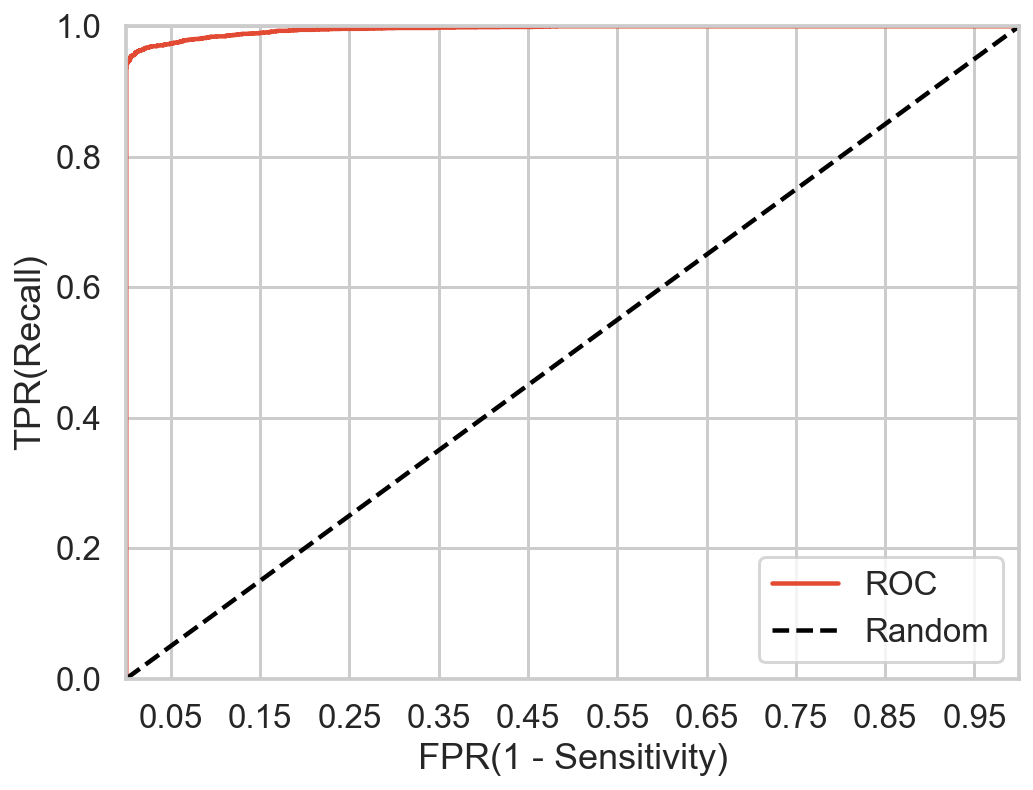

In [69]:
roc_curve_plot(y_smote, best_train_proba_1)

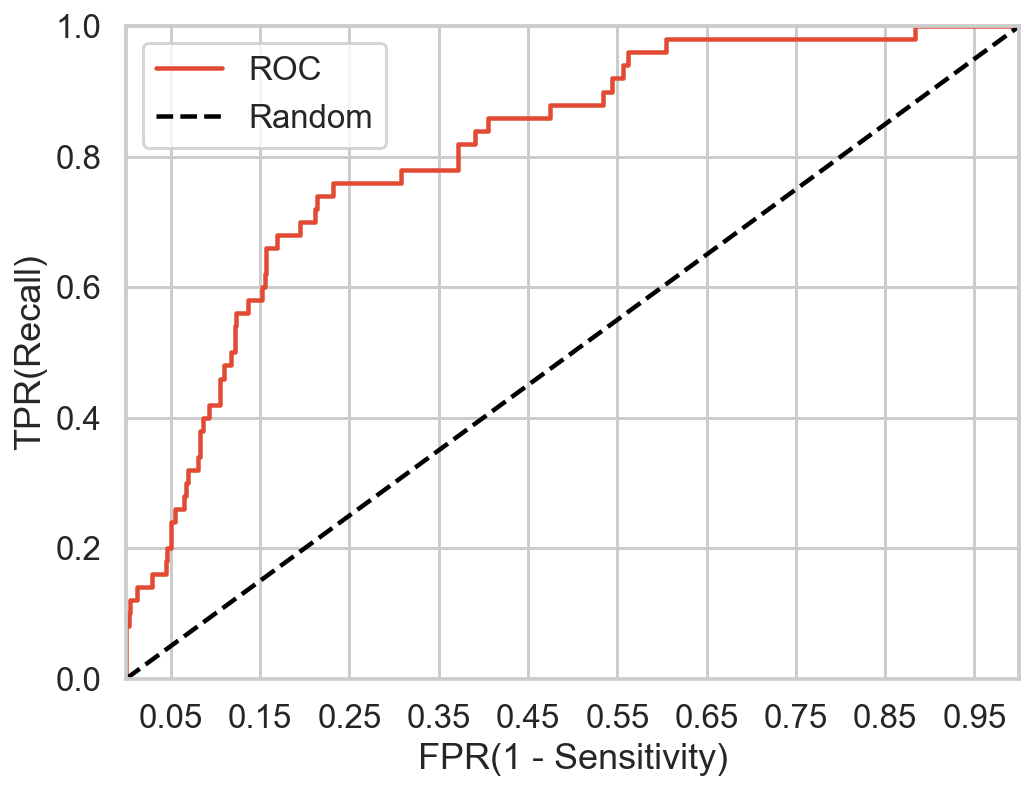

In [70]:
roc_curve_plot(y_test, best_test_proba_1)

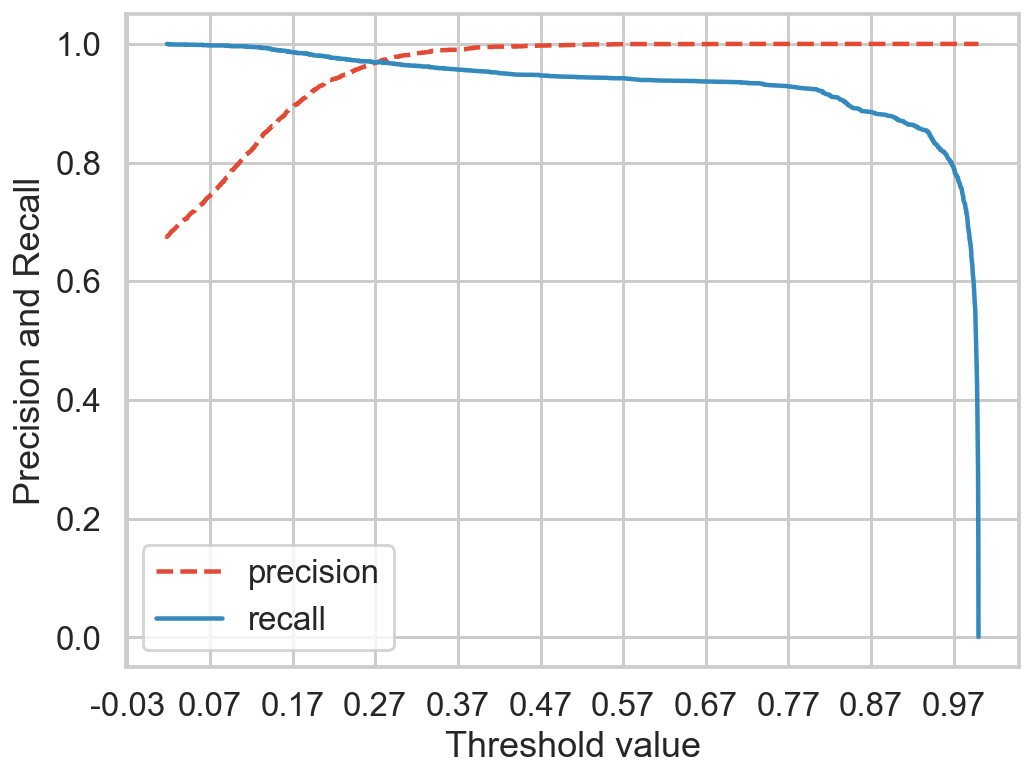

In [71]:
precision_recall_curve_plot(y_smote,best_train_proba_1)

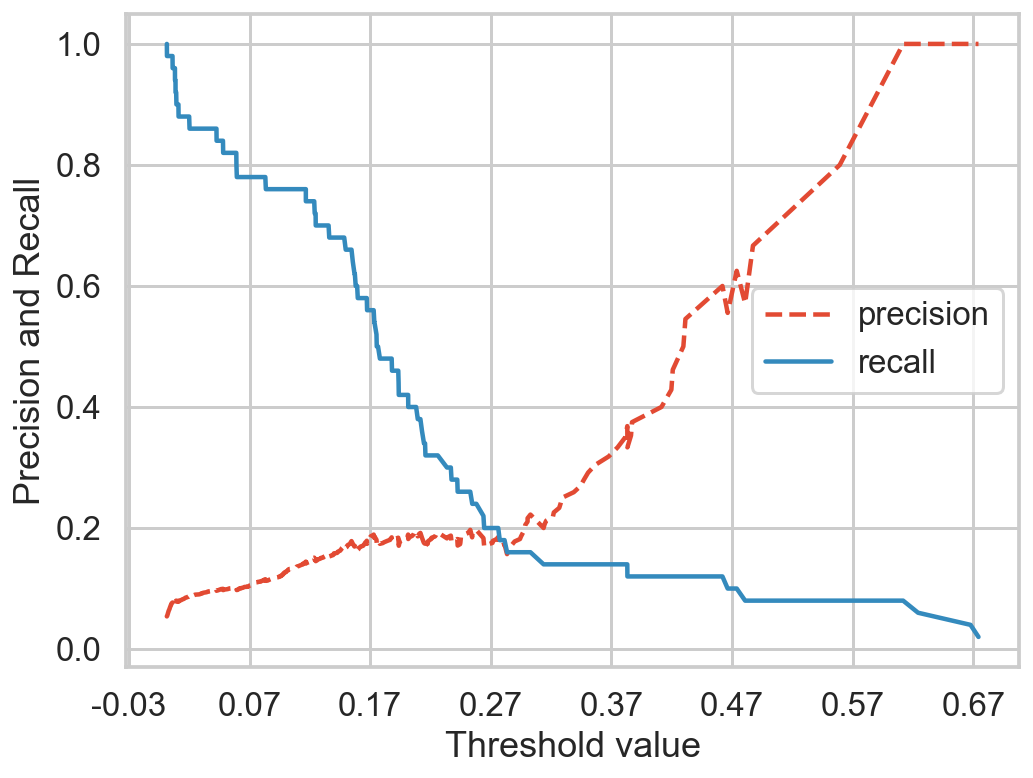

In [72]:
precision_recall_curve_plot(y_test,best_test_proba_1)

## 7. 사후 튜닝

In [88]:
after_pred = (best_test_proba[:,1] > 0.27)*1
after_pred

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
get_clf_eval(y_test,after_pred)

[[925  47]
 [ 40  10]]
정확도 :0.9149, 정밀도 :0.1754, 재현율 :0.2000, F1 :0.1869


In [90]:
after_pred = (best_test_proba[:,1] > 0.07)*1
after_pred

array([0, 0, 1, ..., 0, 0, 0])

In [91]:
get_clf_eval(y_test,after_pred)

[[639 333]
 [ 11  39]]
정확도 :0.6634, 정밀도 :0.1048, 재현율 :0.7800, F1 :0.1848


## 8. 모델 분석

In [61]:
# 피처의 중요도를 추출하기
best_est.feature_importances_

array([0.15490186, 0.21197669, 0.01255495, 0.00990176, 0.05140708,
       0.15346088, 0.10171034, 0.12873252, 0.07524036, 0.10011353],
      dtype=float32)

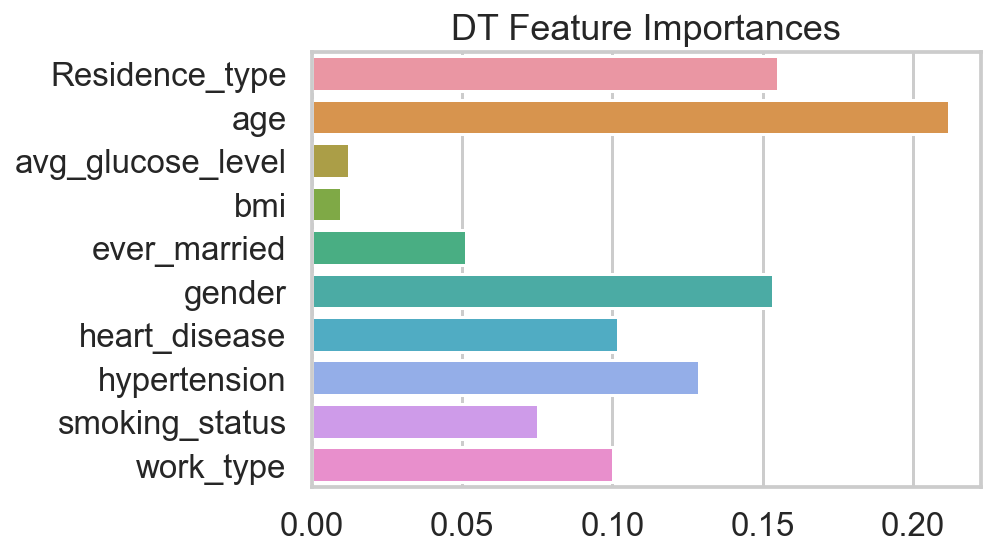

In [62]:
# 피처의 중요도 시각화 하기
plt.title('DT Feature Importances')
sns.barplot(x = best_est.feature_importances_, y = X_data.columns)
plt.show()